# Exercise 1


# 1.Edge Detection

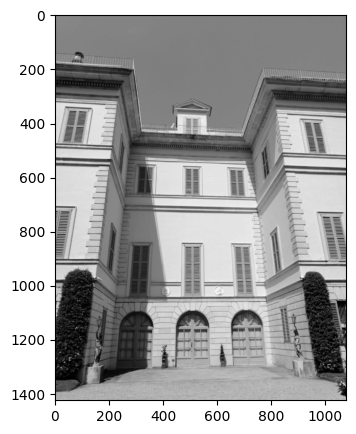

In [7]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

#open image
image_original = cv2.imread('data/villa.png')

#From BGR to grayscale
gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)

#Apply Gaussian Blur to grayscale image
img = cv2.GaussianBlur(gray,(3,3),0)

plt.figure(figsize=(10,5))
plt.imshow(img, cmap='gray')

## 1.1Sobel Edge Detection


Text(0.5, 1.0, 'Sobel X Y')

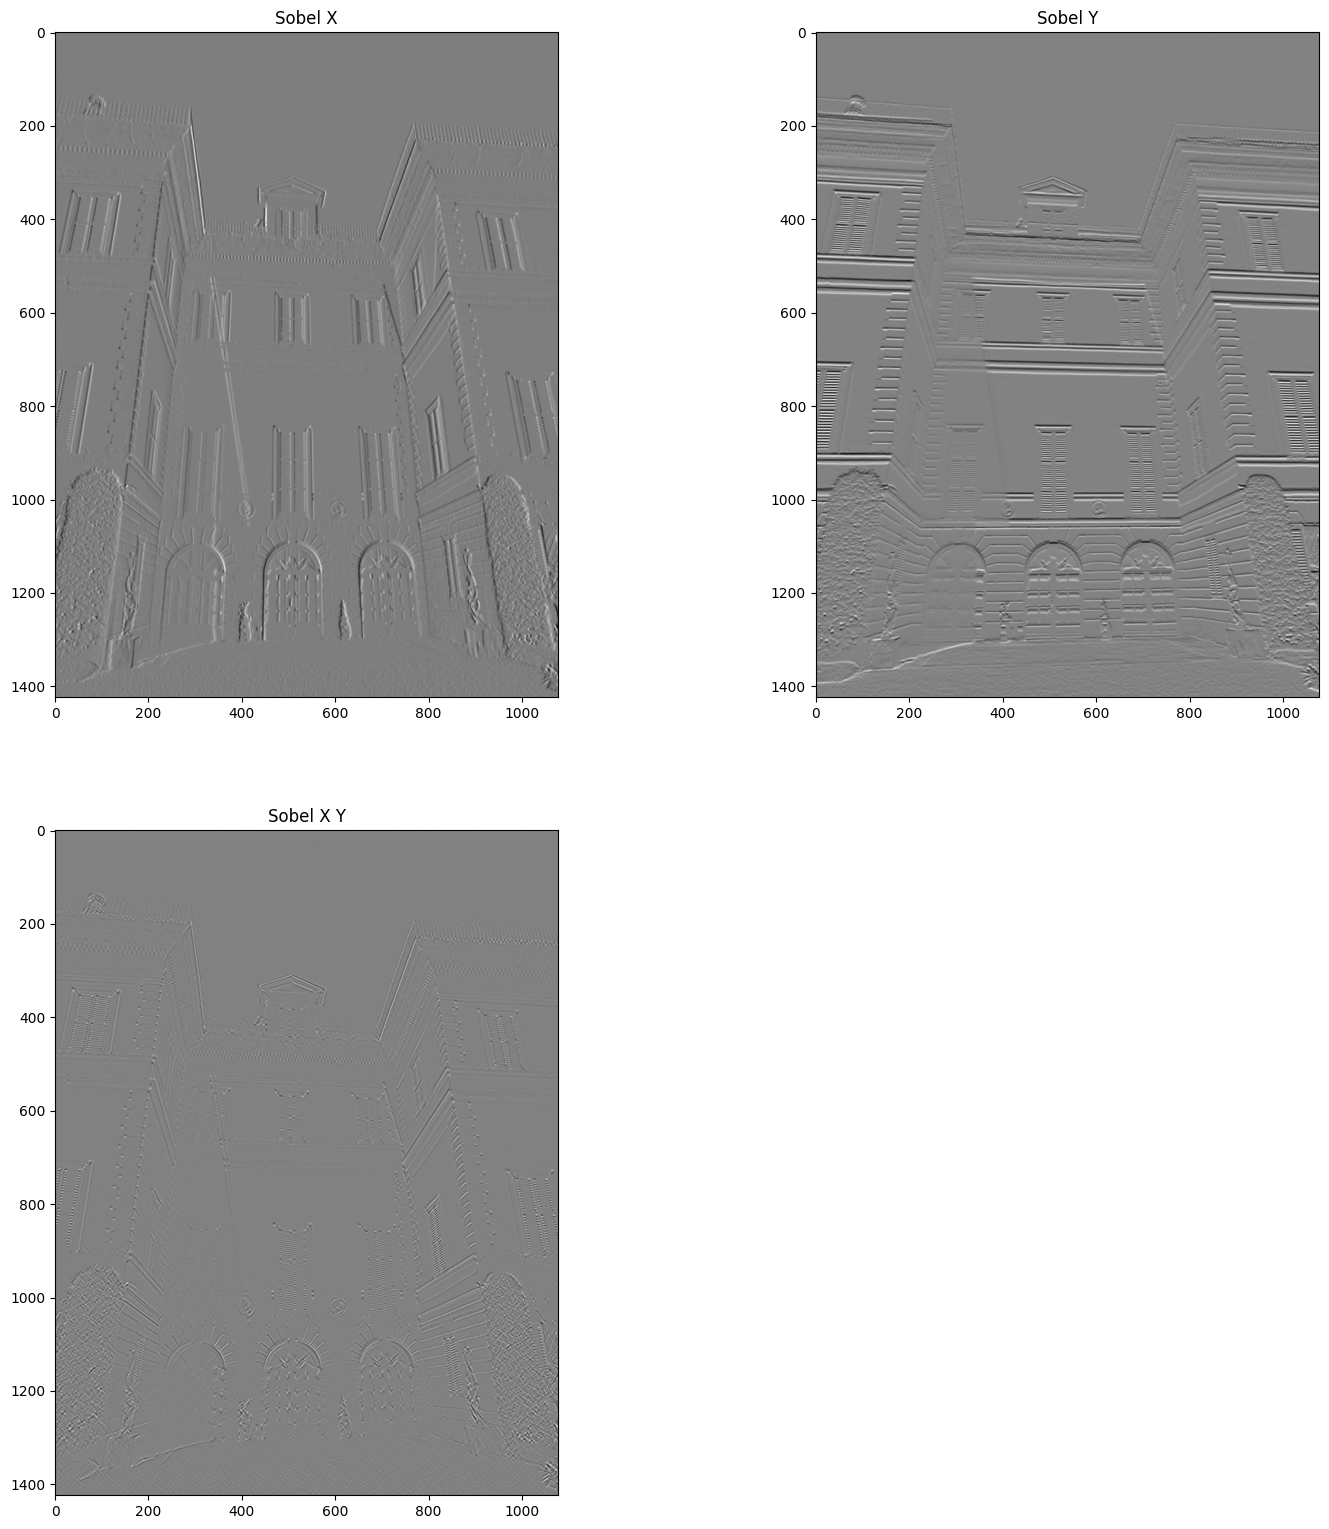

In [8]:
sobelx = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
sobely = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)
sobelxy = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)

plt.figure(figsize=(18,19))

plt.subplot(221)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X')

plt.subplot(222)
plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y')

plt.subplot(223)
plt.imshow(sobelxy, cmap='gray')
plt.title('Sobel X Y')

## 1.2Canny Edge Detection


Text(0.5, 1.0, 'Canny')

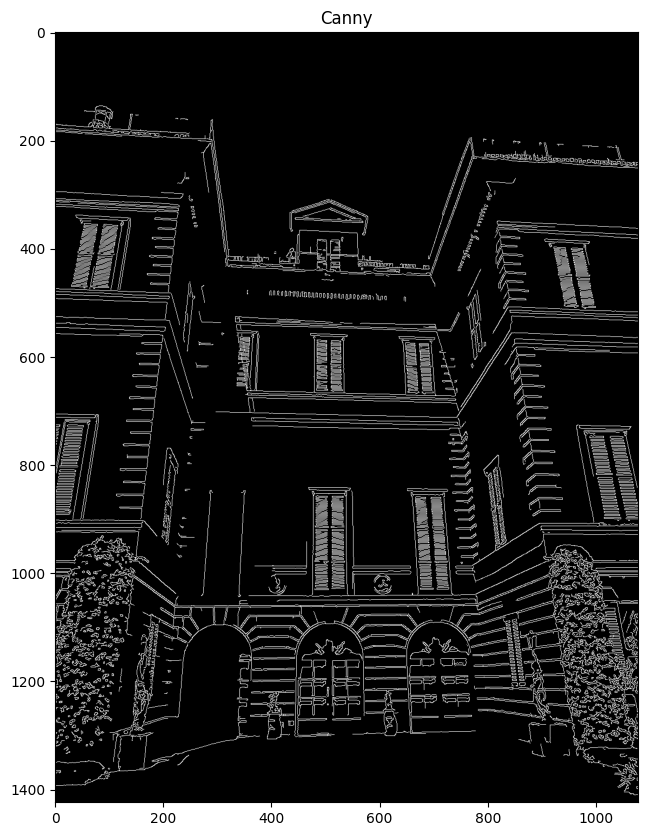

In [9]:
edges = cv2.Canny(image=img, threshold1=100, threshold2=200)
cv2.imwrite("edges.jpg", edges)

plt.figure(figsize=(15,10))
plt.imshow(edges, cmap='gray')
plt.title('Canny')

# 2.Find straight lines through Hough Transform


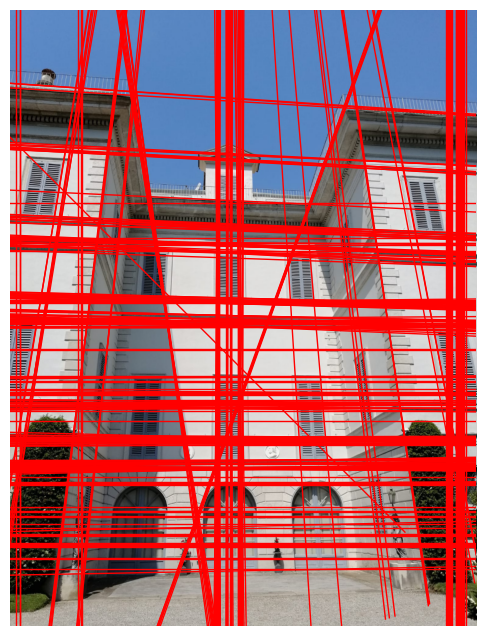

In [10]:
def extract_lines(image, kernel, sigma, rho, theta, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(gray, (kernel, kernel), sigma)
    edges = cv2.Canny(img_blur, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, rho=rho, theta=theta, threshold=threshold)

    return lines

def plot_lines(image, lines):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image[:, :, ::-1])  # Display the image (convert BGR to RGB)
    ax.axis('off')

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1500 * (-b))
            y1 = int(y0 + 1500 * (a))
            x2 = int(x0 - 1500 * (-b))
            y2 = int(y0 - 1500 * (a))
            ax.plot([x1, x2], [y1, y2], color='r', linewidth=1)

    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)
    plt.show()

# Parameters for line extraction
kernel = 7
sigma = 1.5
rho = 0.5
theta = np.pi / 1000
threshold = 120

# Extract lines using specified parameters
lines = extract_lines(image_original, kernel, sigma, rho, theta, threshold)

# Plot the image with detected lines
plot_lines(image_original, lines)


# 3.Corner Detection

## Harris corner detection

//Code From Notebooks provided to us

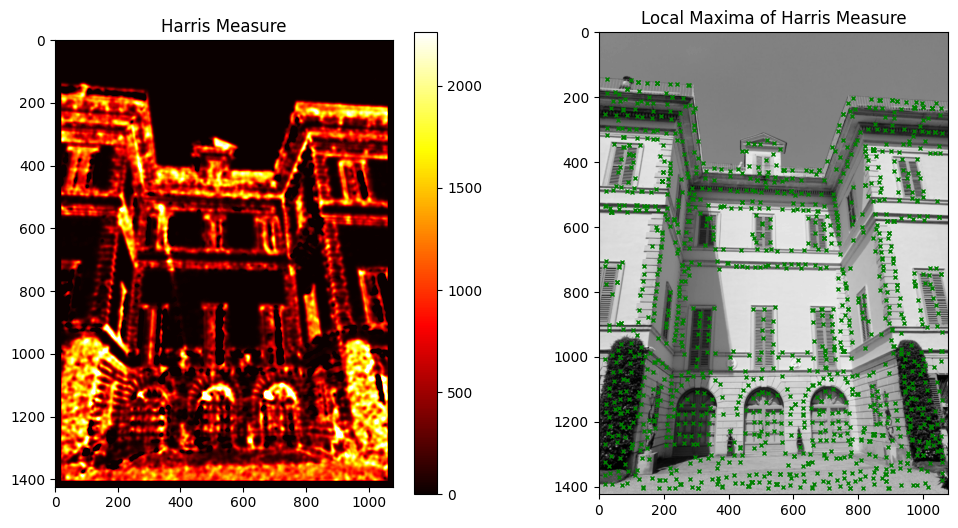

In [11]:
dx_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
dy_kernel = dx_kernel.T


def compute_harris_measure(image, sigma_gaussian=5, k=0.04, threshold_factor=1.0, neighborhood_size=11):

    dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    dy = dx.T.copy()


    #ddepth is set to -1, it means that the destination image will have the same depth as the source image.
    Ix = cv2.filter2D(image, -1, dx)
    Iy = cv2.filter2D(image, -1, dy)


    Iy2 = cv2.GaussianBlur(np.square(Iy), (0, 0), sigma_gaussian) # (0,0) specifies that the size of the filter are computed from the gaussian parameters
    Ix2 = cv2.GaussianBlur(np.square(Ix), (0, 0), sigma_gaussian)
    Ixy = cv2.GaussianBlur(Ix*Iy, (0, 0), sigma_gaussian)
    k = 0.04
    Ix2 = Ix2.astype(np.float64)
    Iy2 = Iy2.astype(np.float64)
    Ixy = Ixy.astype(np.float64)
    # Compute Harris measure
    det_M = Ix2 * Iy2 - np.square(Ixy)
    trace_M = Ix2 + Iy2
    cim = det_M - k * trace_M
    #  remove boundaries of cim which is going to have large values because of zero padding of the image
    BORDER = 20
    cim[:BORDER] = 0
    cim[-BORDER:] = 0
    cim[:, -BORDER:] = 0
    cim[:, :BORDER] = 0

    return cim

def non_maximum_suppression(cim, neighborhood_size=11):
    # Dilate behaves as max filtering
    maxima = cv2.dilate(cim, np.ones((neighborhood_size, neighborhood_size)))

    loc_y, loc_x = np.where((cim == maxima) & (cim > 0))
    return loc_x, loc_y


# Read the image
image = img

# Compute the Harris measure
cim = compute_harris_measure(image)

# Thresholding
threshold = np.mean(cim)
CIM = np.where(cim > threshold, cim, 0)

# Non-maximum suppression
loc_x, loc_y = non_maximum_suppression(CIM,neighborhood_size=15)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cim.astype(np.float64), cmap='hot', vmin=np.quantile(
    CIM, 0), vmax=np.quantile(CIM, 0.995))
plt.title('Harris Measure')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.plot(loc_x, loc_y, 'gx', markersize=3, linewidth=3)
plt.title('Local Maxima of Harris Measure')
plt.show()